In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from glob import glob
import cv2
from tqdm import tqdm
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

In [6]:
image_train_path = "dataset/food_data/Train"
image_test_path = "dataset/food_data/Test"
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
  image_train_path,
  target_size=(224, 224),
  batch_size=64,
  class_mode="categorical" 
)
validation_generator = test_gen.flow_from_directory(
  image_test_path,
  target_size=(224, 224),
  batch_size=64,
  class_mode="categorical" 
)

Found 2615 images belonging to 15 classes.
Found 746 images belonging to 15 classes.


In [7]:
# Class labels
class_labels = train_generator.class_indices
print(class_labels)
print(train_generator.classes)

{'ayam goreng krispi': 0, 'bakso': 1, 'burger': 2, 'kentang goreng': 3, 'nasi goreng': 4, 'nasi padang': 5, 'nasi putih': 6, 'nugget': 7, 'pizza': 8, 'rawon daging sapi': 9, 'rendang': 10, 'sate': 11, 'seblak': 12, 'sop': 13, 'tempe goreng': 14}
[ 0  0  0 ... 14 14 14]


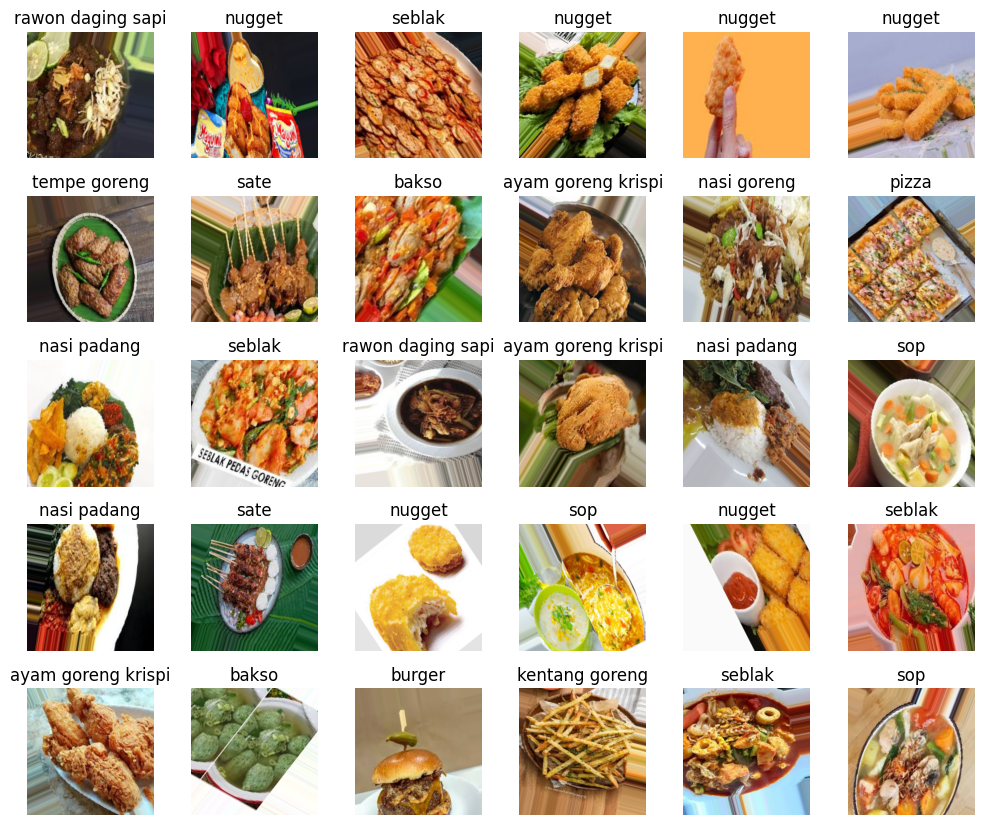

In [8]:
image, label = next(train_generator)
class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(10, 10))

for i in range(30):
    img, label = next(train_generator)
    plt.subplot(6,6, i+1)
    plt.imshow(img[0])
    plt.title(class_names[label[0].argmax()])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [9]:
x_data = []
y_data = []

for category in glob(image_train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 175/175 [00:00<00:00, 1886.47it/s]


In [10]:
mobilenet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                                                                    include_top=False,
                                                                    weights='imagenet')

# Unfreeze some layers of MobileNetV2 for fine-tuning
mobilenet_model.trainable = True
for layer in mobilenet_model.layers[:100]:
    layer.trainable = False

# Add custom layers with regularization
x = mobilenet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(len(class_labels), activation='softmax')(x)

model = tf.keras.models.Model(inputs=mobilenet_model.input, outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [12]:
BATCH_SIZE = 64
# Train the model with data augmentation and callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)


/Users/user/.pyenv/versions/3.12.6/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.1693 - loss: 20.5473 - val_accuracy: 0.6065 - val_loss: 18.4854 - learning_rate: 1.0000e-04
Epoch 2/50
 1/40 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.4688 - loss: 18.7932

/Users/user/.pyenv/versions/3.12.6/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.4688 - loss: 18.7932 - val_accuracy: 0.6264 - val_loss: 18.3894 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.6189 - loss: 18.0922 - val_accuracy: 0.7571 - val_loss: 16.6452 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 0.7344 - loss: 16.6460 - val_accuracy: 0.7571 - val_loss: 16.6043 - learning_rate: 1.0000e-04
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7607 - loss: 16.3375 - val_accuracy: 0.7472 - val_loss: 15.4700 - learning_rate: 1.0000e-04
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 0.8438 - loss: 15.3555 - val_accuracy: 0.7457 - val_loss: 15.4241 - learning_rate: 1.0000e-04
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.8281 - loss: 14.9995 - val_accuracy: 0.7969 - val_loss: 14.3125 - learning_rate: 1.0000e-04
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.

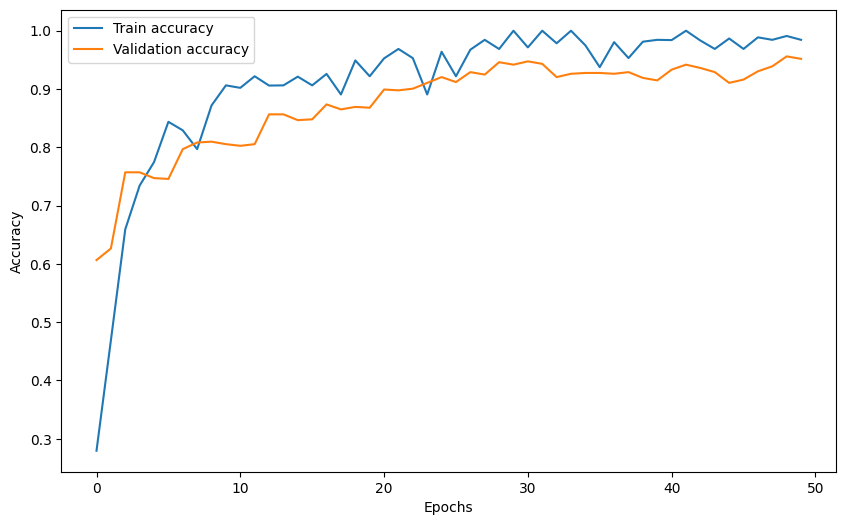

In [13]:
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

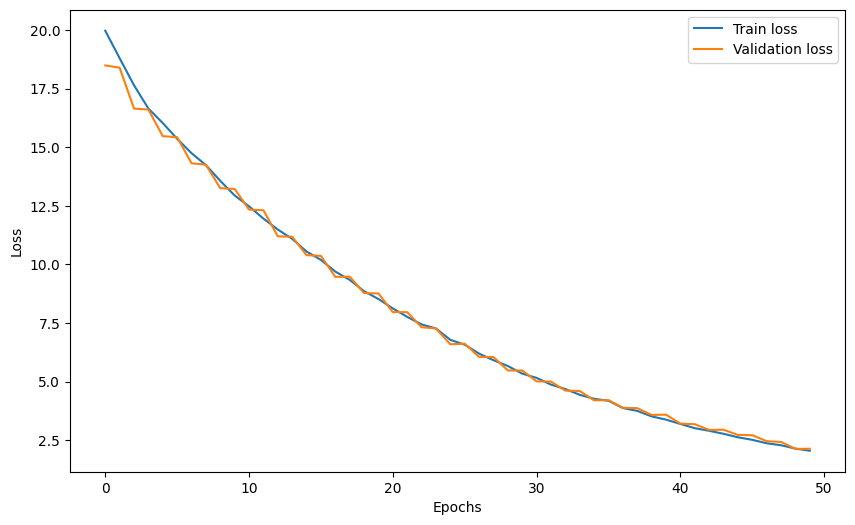

In [14]:
plt.figure(figsize=[10,6])
plt.plot(history.history["loss"], label = "Train loss")
plt.plot(history.history["val_loss"], label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
model.save("food_image2.h5")

In [16]:
model.load_weights('food_image2.h5')
evaluation = model.evaluate(validation_generator)
print(f"Validation Accuracy: {evaluation[1] * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 926ms/step - accuracy: 0.9528 - loss: 2.1444
Validation Accuracy: 95.44%


In [17]:
image,labels =next(validation_generator)
predictions = model.predict(image)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step 


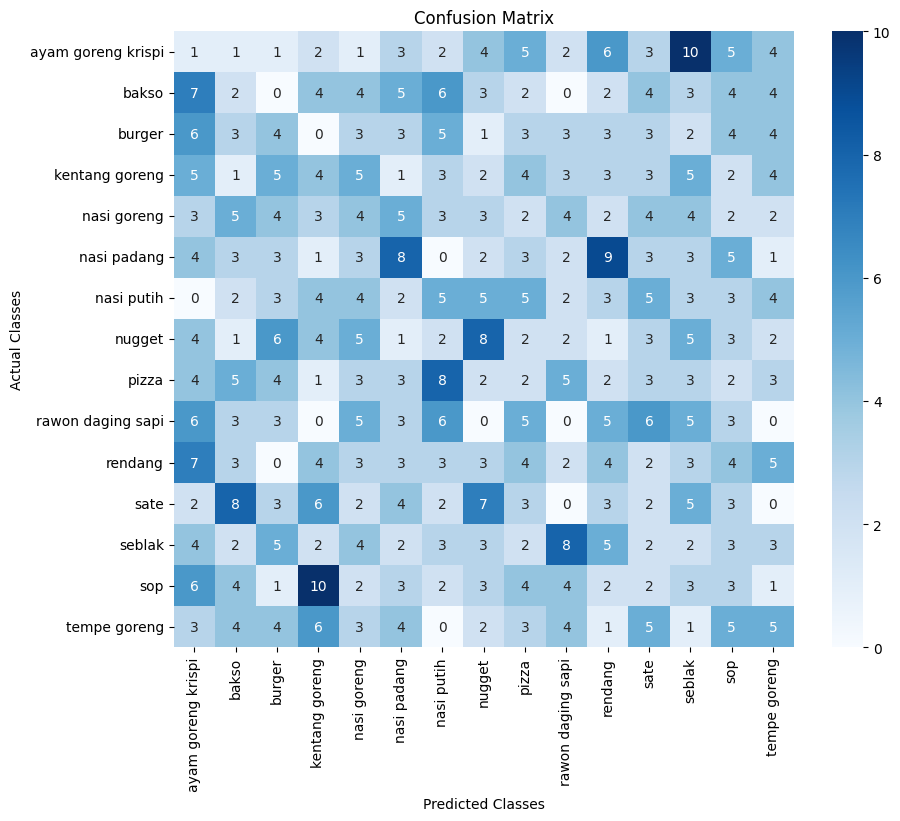

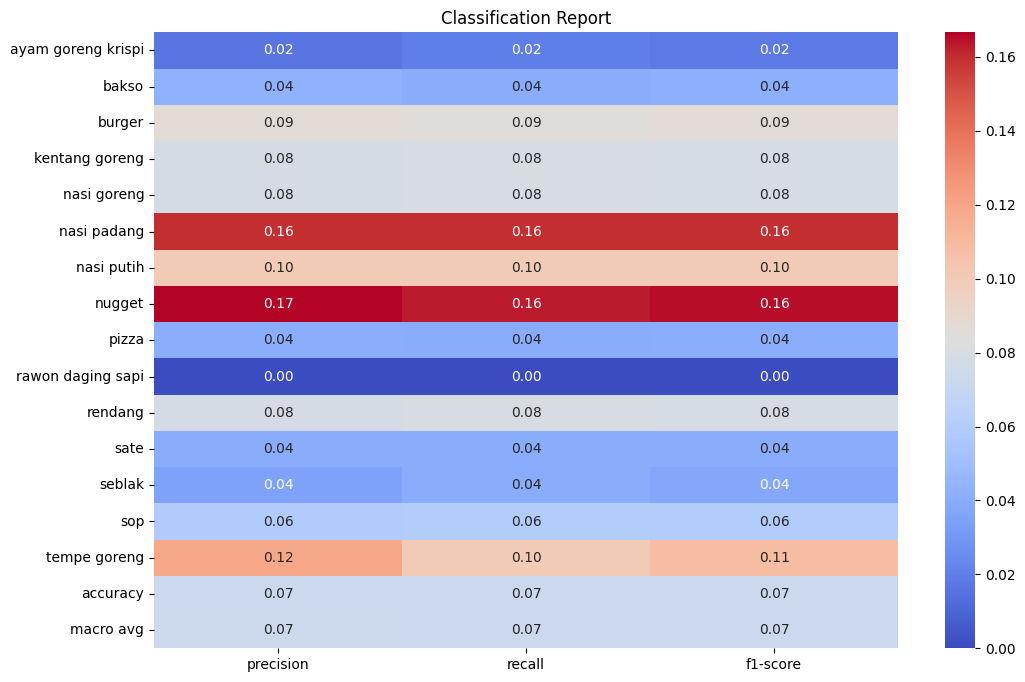

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
# Confusion Matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()
# Classification Report
report = classification_report(validation_generator.classes, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(12, 8))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step


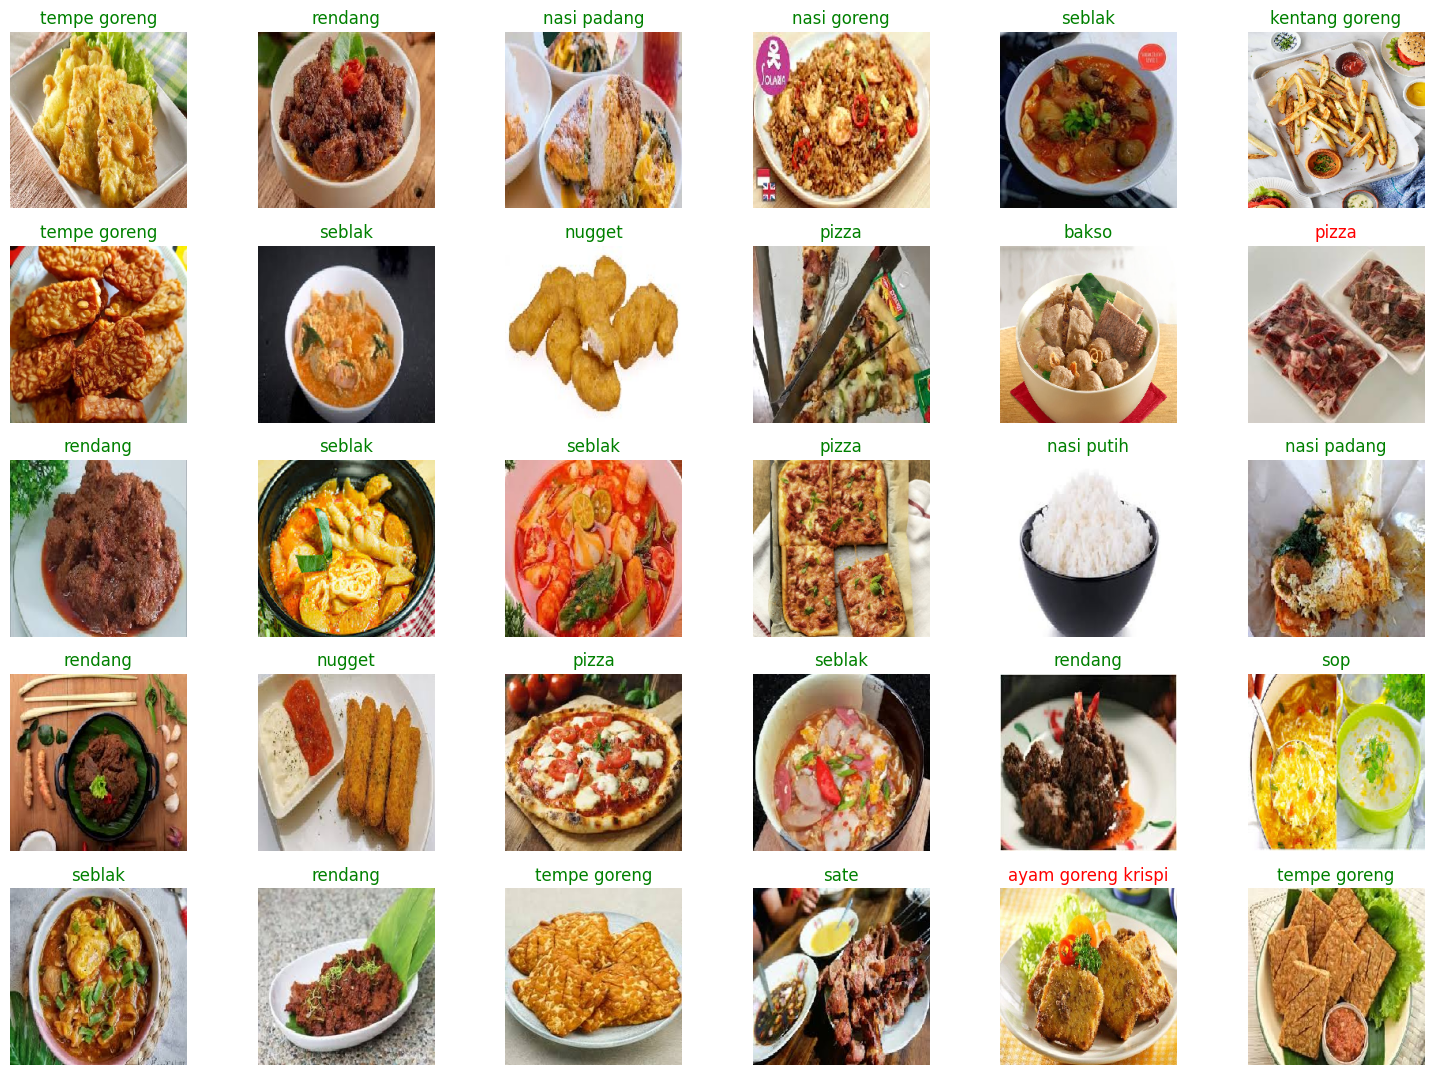

In [19]:
predictions = model.predict(image)

class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 13))
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(image[i])

    pred_label = np.argmax(predictions[i])
    true_label = np.argmax(labels[i])

    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.title(class_names[pred_label], color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [20]:
# Dataset nutrisi makanan
dataset_makanan = {
    0: {'nama': 'ayam goreng krispi', 'protein': 20, 'lemak': 15, 'karbohidrat': 10, 'kalori': 255},
    1: {'nama': 'bakso', 'protein': 12, 'lemak': 8, 'karbohidrat': 15, 'kalori': 180},
    2: {'nama': 'burger', 'protein': 15, 'lemak': 20, 'karbohidrat': 30, 'kalori': 360},
    3: {'nama': 'kentang goreng', 'protein': 2, 'lemak': 15, 'karbohidrat': 35, 'kalori': 280},
    4: {'nama': 'nasi goreng', 'protein': 8, 'lemak': 10, 'karbohidrat': 45, 'kalori': 300},
    5: {'nama': 'nasi padang', 'protein': 20, 'lemak': 15, 'karbohidrat': 60, 'kalori': 450},
    6: {'nama': 'nasi putih', 'protein': 3, 'lemak': 0, 'karbohidrat': 40, 'kalori': 172},
    7: {'nama': 'nugget', 'protein': 10, 'lemak': 12, 'karbohidrat': 15, 'kalori': 208},
    8: {'nama': 'pizza', 'protein': 12, 'lemak': 14, 'karbohidrat': 35, 'kalori': 310},
    9: {'nama': 'rawon daging sapi', 'protein': 18, 'lemak': 12, 'karbohidrat': 20, 'kalori': 260},
    10: {'nama': 'rendang', 'protein': 25, 'lemak': 20, 'karbohidrat': 5, 'kalori': 330},
    11: {'nama': 'sate', 'protein': 20, 'lemak': 15, 'karbohidrat': 10, 'kalori': 250},
    12: {'nama': 'seblak', 'protein': 8, 'lemak': 10, 'karbohidrat': 30, 'kalori': 240},
    13: {'nama': 'sop', 'protein': 10, 'lemak': 5, 'karbohidrat': 15, 'kalori': 140},
    14: {'nama': 'tempe goreng', 'protein': 15, 'lemak': 10, 'karbohidrat': 8, 'kalori': 182}
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


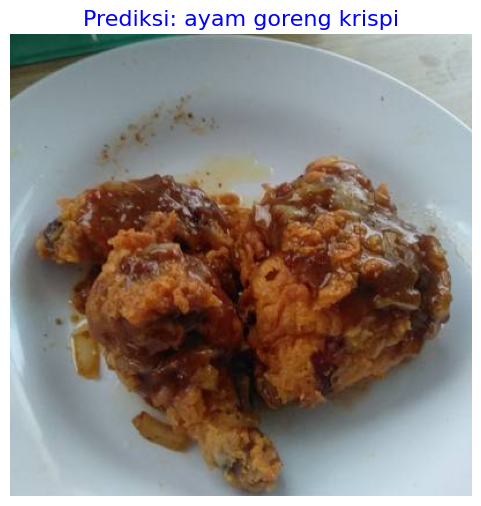


Informasi Nutrisi:
nama: ayam goreng krispi
protein: 20
lemak: 15
karbohidrat: 10
kalori: 255


In [24]:
# Load the model
model = load_model('food_image2.h5')

def predict_image(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    max_probability = np.max(prediction[0])
    
    class_labels = {0: 'ayam goreng krispi', 1: 'bakso', 2: 'burger', 3: 'kentang goreng', 4: 'nasi goreng', 5: 'nasi padang', 6: 'nasi putih', 7: 'nugget', 8: 'pizza', 9: 'rawon daging sapi', 10: 'rendang', 11: 'sate', 12: 'seblak', 13: 'sop', 14: 'tempe goreng'}
    
    if max_probability >= 0.6:
        predicted_class = np.argmax(prediction)
        return class_labels[predicted_class]
    else:
        return "Makanan tidak dikenali"

image_path = 'ayam2.jpg'
predicted_label = predict_image(image_path, model)

# Fungsi untuk memprediksi nutrisi
def prediksi_nutrisi(nama_makanan):
    for label, makanan in dataset_makanan.items():
        if makanan['nama'] == nama_makanan:
            return makanan
    return "Nutrisi Makanan tidak ditemukan dalam dataset"

plt.figure(figsize=(6, 6))
plt.imshow(load_img(image_path))
plt.axis('off')
plt.title(f"Prediksi: {predicted_label}", fontsize=16, color='blue')
plt.show()

if predicted_label != "Makanan tidak dikenali":
    hasil_nutrisi = prediksi_nutrisi(predicted_label)
    if isinstance(hasil_nutrisi, dict):
        print("\nInformasi Nutrisi:")
        for key, value in hasil_nutrisi.items():
            print(f"{key}: {value}")
    else:
        print(hasil_nutrisi)
else:
    print("Tidak dapat memprediksi nutrisi karena makanan tidak dikenali.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


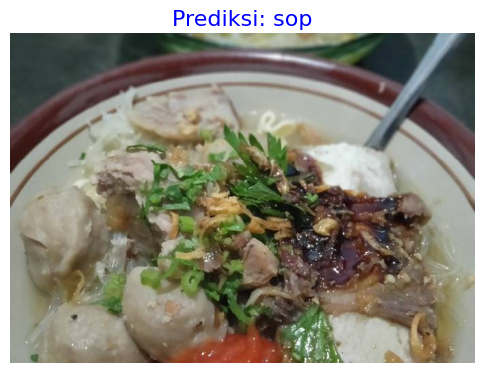


Informasi Nutrisi:
nama: sop
protein: 10
lemak: 5
karbohidrat: 15
kalori: 140


In [28]:
# Load the model
model = load_model('food_image2.h5')

def predict_image(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    
    img_array = img_to_array(img) / 255.0
    
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    
    predicted_class = np.argmax(prediction)
    
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    predicted_label = class_labels[predicted_class]

    return predicted_label
image_path = 'bakso.jpg'
predicted_label = predict_image(image_path, model)

# Fungsi untuk memprediksi nutrisi
def prediksi_nutrisi(nama_makanan):
    for label, makanan in dataset_makanan.items():
        if makanan['nama'] == nama_makanan:
            return makanan
    return "Nutrisi Makanan tidak ditemukan dalam dataset"

plt.figure(figsize=(6, 6))
plt.imshow(load_img(image_path))
plt.axis('off')
plt.title(f"Prediksi: {predicted_label}", fontsize=16, color='blue')
plt.show()

hasil_nutrisi = prediksi_nutrisi(predicted_label)
if isinstance(hasil_nutrisi, dict):
    print("\nInformasi Nutrisi:")
    for key, value in hasil_nutrisi.items():
        print(f"{key}: {value}")
else:
    print(hasil_nutrisi)


In [29]:
# ini mode yang asli
mobilenet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                                                                        include_top=False,
                                                                        weights='imagenet')
# Freeze MobileNetV2 layers
mobilenet_model.trainable = False
# Add custom layers
x = mobilenet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
output = tf.keras.layers.Dense(len(class_labels), activation='softmax')(x) 
# Build final model
model = tf.keras.models.Model(inputs=mobilenet_model.input, outputs=output)

# Summary model
model.summary()

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,102,223 (15.65 MB)

 Trainable params: 1,844,239 (7.04 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
# Definisikan callbacks
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
best_model = ModelCheckpoint(
    'cnn1.keras',
    monitor='val_loss',
    save_best_only=True
)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [31]:
# Fine-tune model
history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[best_model, early_stopping_monitor]
)

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 867ms/step - accuracy: 0.4576 - loss: 1.8297 - val_accuracy: 0.8150 - val_loss: 0.6002
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 764ms/step - accuracy: 0.7541 - loss: 0.7752 - val_accuracy: 0.8660 - val_loss: 0.4194
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 861ms/step - accuracy: 0.8326 - loss: 0.5243 - val_accuracy: 0.8861 - val_loss: 0.3880
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 907ms/step - accuracy: 0.8342 - loss: 0.4853 - val_accuracy: 0.8968 - val_loss: 0.3241
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 846ms/step - accuracy: 0.8577 - loss: 0.4257 - val_accuracy: 0.8995 - val_loss: 0.3282
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 868ms/step - accuracy: 0.8779 - loss: 0.3583 - val_accuracy: 0.9021 - val_loss: 0.3220
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 894ms/step - accuracy: 0.8831 - loss: 0.3430 - val_accuracy: 0.8901 - val_loss: 0.3306
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 897ms/step - accuracy: 0.9053 - loss: 0.3010 - val_accu

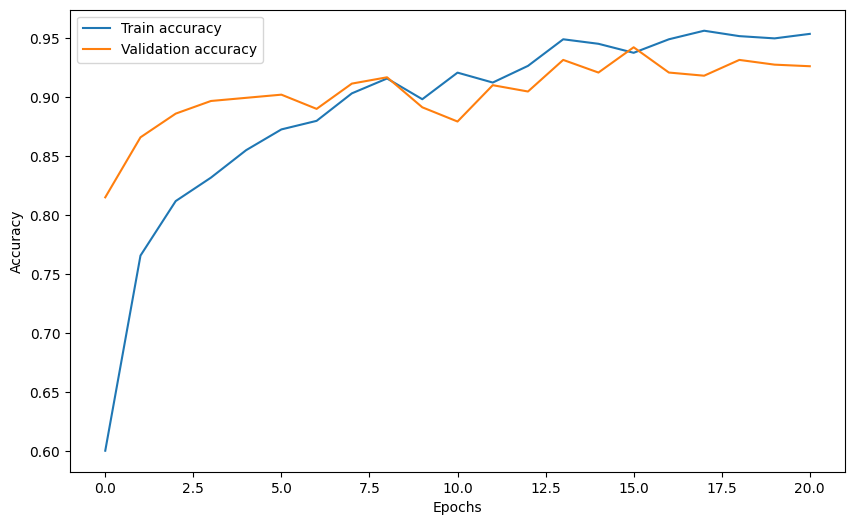

In [32]:
plt.figure(figsize=[10,6])
plt.plot(history_finetune.history["accuracy"], label = "Train accuracy")
plt.plot(history_finetune.history["val_accuracy"], label = "Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

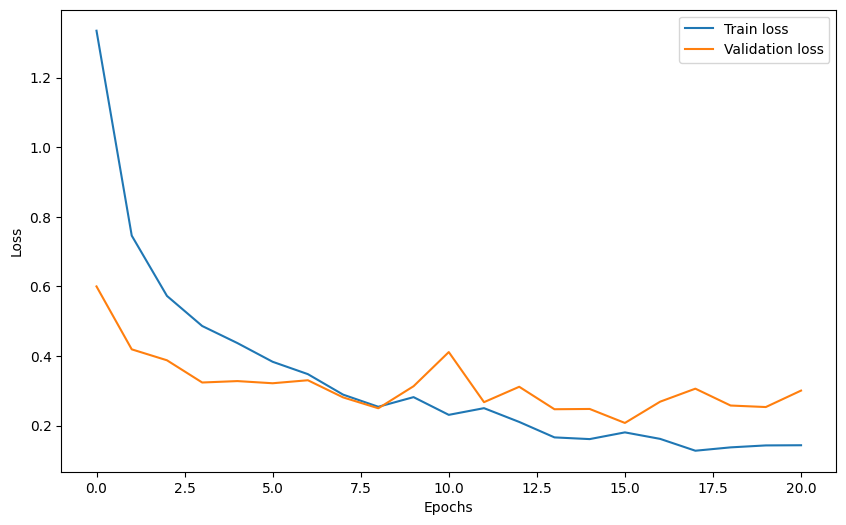

In [33]:
plt.figure(figsize=[10,6])
plt.plot(history_finetune.history["loss"], label = "Train loss")
plt.plot(history_finetune.history["val_loss"], label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [34]:
model.save("food_image1.h5")

In [35]:
model.load_weights('food_image1.h5')
evaluation = model.evaluate(validation_generator)
print(f"Validation Accuracy: {evaluation[1] * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 611ms/step - accuracy: 0.9386 - loss: 0.1842
Validation Accuracy: 94.24%


In [36]:
image,labels =next(validation_generator)
predictions = model.predict(image)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 686ms/step


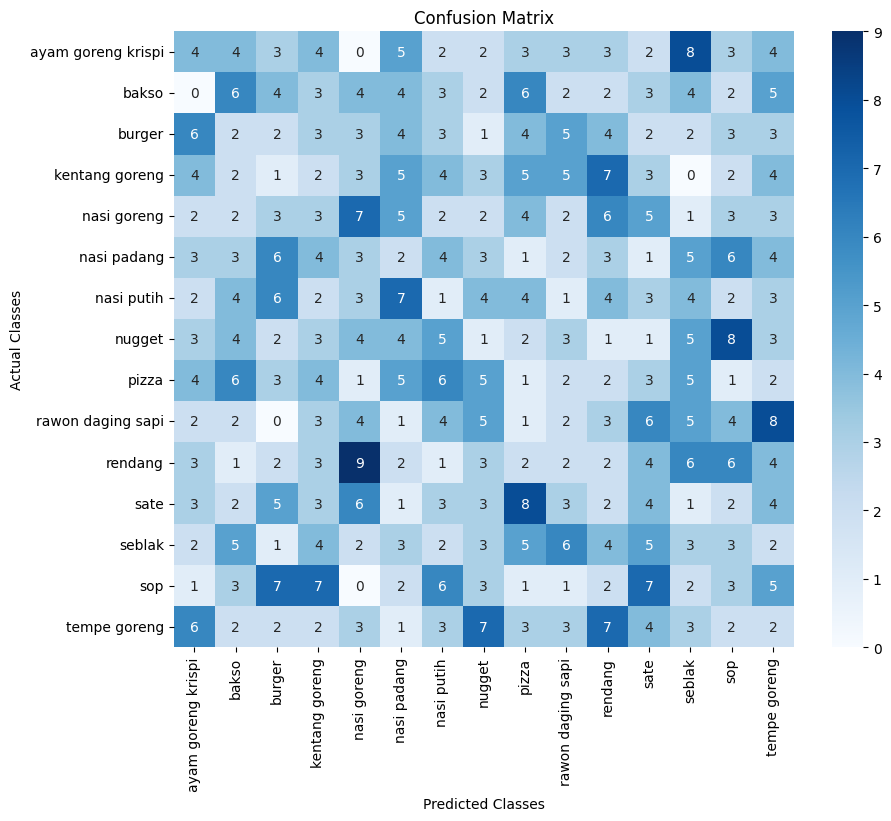

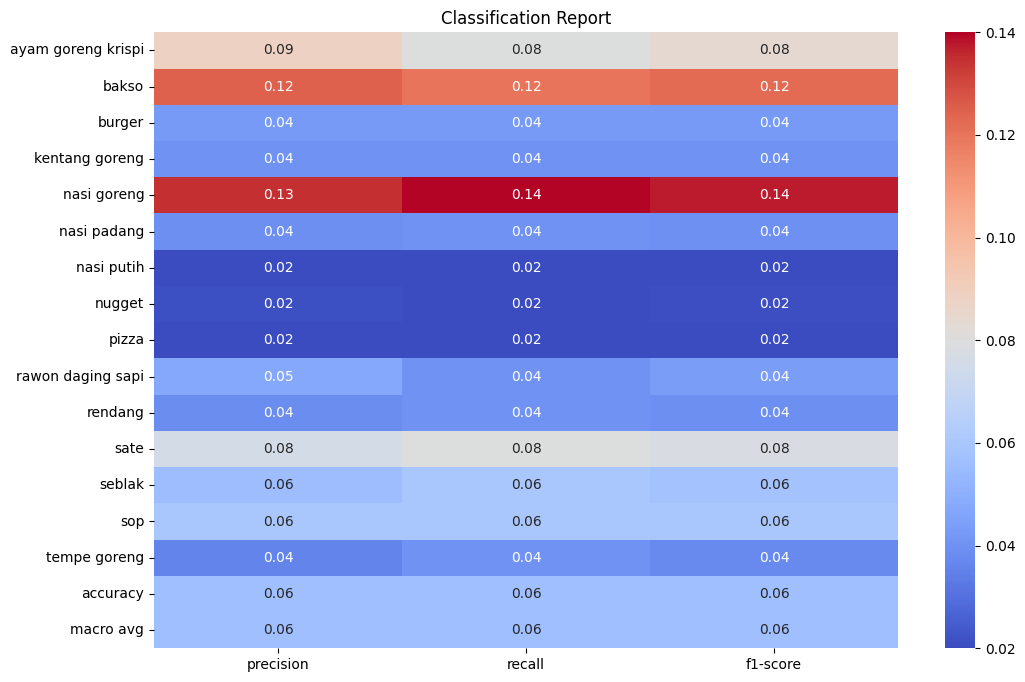

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
# Confusion Matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()
# Classification Report
report = classification_report(validation_generator.classes, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(12, 8))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step


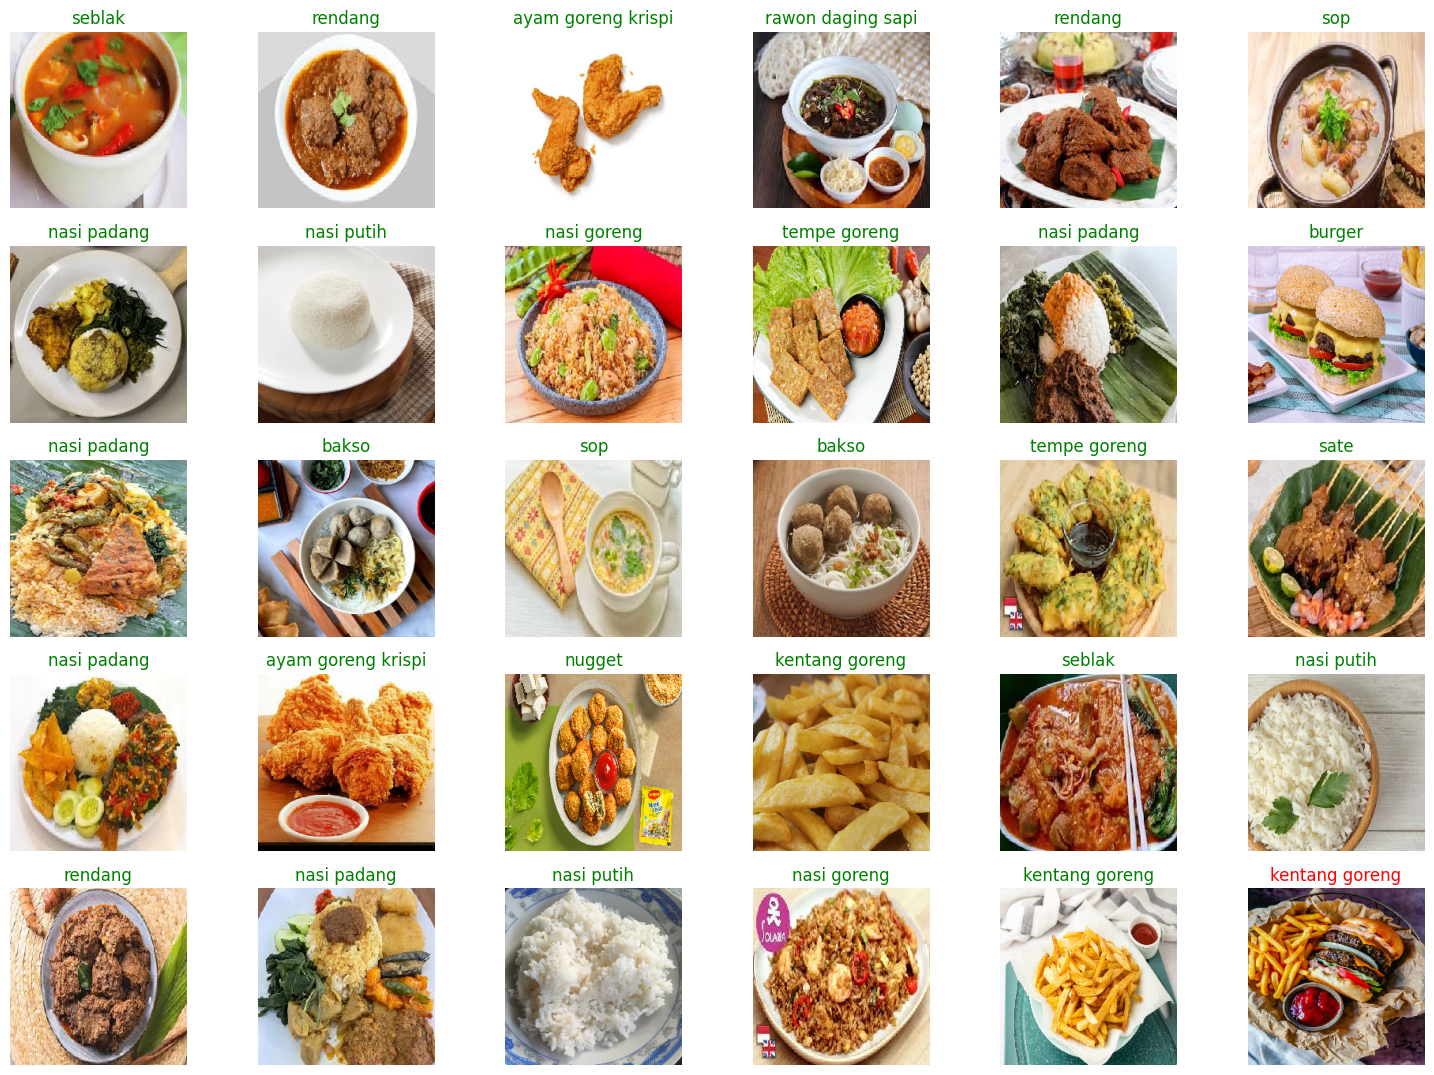

In [43]:
predictions = model.predict(image)

class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 13))
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(image[i])

    pred_label = np.argmax(predictions[i])
    true_label = np.argmax(labels[i])

    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.title(class_names[pred_label], color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


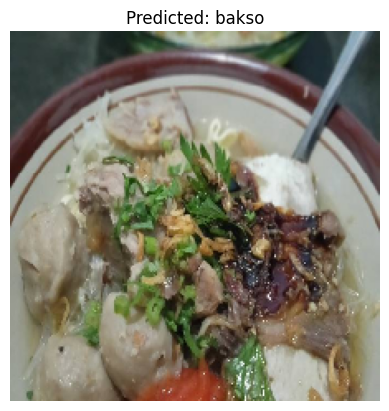

Predicted Label: bakso


In [45]:
# Load the model
model = load_model('food_image1.h5')

def predict_image(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    
    img_array = img_to_array(img) / 255.0
    
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    
    predicted_class = np.argmax(prediction)
    
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    predicted_label = class_labels[predicted_class]
    
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label
image_path = 'bakso.jpg'
predicted_label = predict_image(image_path, model)
print(f"Predicted Label: {predicted_label}")


In [46]:
model = load_model('food_image1.h5')

# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
with open('food_image.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/7h/kf6d0p197m315hsd0_tymsgr0000gn/T/tmp7y0haoys/assets


INFO:tensorflow:Assets written to: /var/folders/7h/kf6d0p197m315hsd0_tymsgr0000gn/T/tmp7y0haoys/assets


Saved artifact at '/var/folders/7h/kf6d0p197m315hsd0_tymsgr0000gn/T/tmp7y0haoys'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  6078569104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078567184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078567568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078567952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078568720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078565840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078564112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078563920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078563344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078565648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6078564880: Tensor

W0000 00:00:1736315645.531327 8116415 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1736315645.531896 8116415 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-08 12:54:05.538957: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/7h/kf6d0p197m315hsd0_tymsgr0000gn/T/tmp7y0haoys
2025-01-08 12:54:05.546615: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-08 12:54:05.546631: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/7h/kf6d0p197m315hsd0_tymsgr0000gn/T/tmp7y0haoys
I0000 00:00:1736315645.625115 8116415 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-01-08 12:54:05.639841: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-08 12:54:06.279795: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder

In [47]:
# Dataset nutrisi makanan
dataset_makanan = {
    0: {'nama': 'ayam goreng krispi', 'protein': 20, 'lemak': 15, 'karbohidrat': 10, 'kalori': 255, 'serat': 0.5, 'gula': 0, 'natrium': 400},
    1: {'nama': 'bakso', 'protein': 12, 'lemak': 8, 'karbohidrat': 15, 'kalori': 180, 'serat': 1, 'gula': 1, 'natrium': 600},
    2: {'nama': 'burger', 'protein': 15, 'lemak': 20, 'karbohidrat': 30, 'kalori': 360, 'serat': 2, 'gula': 5, 'natrium': 500},
    3: {'nama': 'kentang goreng', 'protein': 2, 'lemak': 15, 'karbohidrat': 35, 'kalori': 280, 'serat': 3, 'gula': 0, 'natrium': 200},
    4: {'nama': 'nasi goreng', 'protein': 8, 'lemak': 10, 'karbohidrat': 45, 'kalori': 300, 'serat': 2, 'gula': 2, 'natrium': 800},
    5: {'nama': 'nasi putih', 'protein': 3, 'lemak': 0, 'karbohidrat': 40, 'kalori': 172, 'serat': 0, 'gula': 0, 'natrium': 1},
    6: {'nama': 'nugget', 'protein': 10, 'lemak': 12, 'karbohidrat': 15, 'kalori': 208, 'serat': 1, 'gula': 0, 'natrium': 450},
    7: {'nama': 'pizza', 'protein': 12, 'lemak': 14, 'karbohidrat': 35, 'kalori': 310, 'serat': 2, 'gula': 3, 'natrium': 600},
    8: {'nama': 'rawon daging sapi', 'protein': 18, 'lemak': 12, 'karbohidrat': 20, 'kalori': 260, 'serat': 2, 'gula': 1, 'natrium': 700},
    9: {'nama': 'tempe goreng', 'protein': 15, 'lemak': 10, 'karbohidrat': 8, 'kalori': 182, 'serat': 3, 'gula': 0, 'natrium': 9}
}

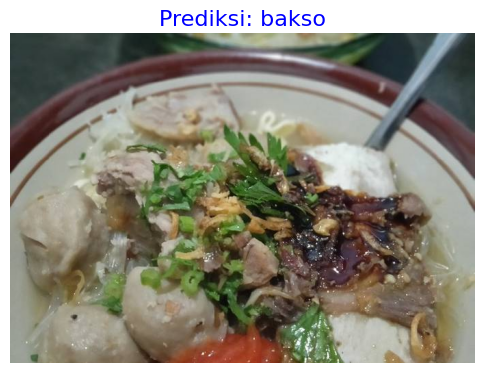


Informasi Nutrisi:
nama: bakso
protein: 12
lemak: 8
karbohidrat: 15
kalori: 180
serat: 1
gula: 1
natrium: 600


In [48]:
# Fungsi untuk memprediksi nutrisi
def prediksi_nutrisi(nama_makanan):
    for label, makanan in dataset_makanan.items():
        if makanan['nama'] == nama_makanan:
            return makanan
    return "Nutrisi Makanan tidak ditemukan dalam dataset"

# Menampilkan gambar input
plt.figure(figsize=(6, 6))
plt.imshow(load_img(image_path))
plt.axis('off')
plt.title(f"Prediksi: {predicted_label}", fontsize=16, color='blue')
plt.show()

# Menggunakan hasil prediksi gambar untuk mendapatkan informasi nutrisi
hasil_nutrisi = prediksi_nutrisi(predicted_label)
if isinstance(hasil_nutrisi, dict):
    print("\nInformasi Nutrisi:")
    for key, value in hasil_nutrisi.items():
        print(f"{key}: {value}")
else:
    print(hasil_nutrisi)